# Find the central star of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : June 14 th 2017


The goal of this notebook is to cut a part of the image around the main central star.
The rest of the image is useless.
This region around the central star is necessary to perform the rotation of the images without
any biases due to other stars.

- very simple max
- sub-image where to find the target star
- no special star finder because the star image may be defocused


In [1]:
#%%javascript
#var kernel = IPython.notebook.kernel;
#var thename = window.document.getElementById("notebook_name").innerHTML;
#var command = "theNotebook = " + "'"+thename+"'";
#kernel.execute(command);

In [2]:
#print theNotebook

In [3]:
theNotebook="FindCentralStarFast"

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
import math as m

In [5]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [6]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [7]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [8]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind # deprecated
from photutils import DAOStarFinder
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [9]:
%load_ext Cython

In [10]:
from IPython.display import Image, display

In [11]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [12]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [13]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)¶

In [14]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [15]:
ensure_dir(dir_top_images) # create that directory

### Input directory

In [16]:
inputdir="reduced_fitsimages"
MIN_IMGNUMBER=46
MAX_IMGNUMBER=55
object_name='HD111980 May 31th 2017'
SelectTagRe='^reduc_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^reduc_20170531_[0-9]+.fits$'
NBIMGPERLROW=4
BigFigSize=(20,50)

### Output directory fot fits images

In [17]:
outputdir="./cut_fitsimages"

In [18]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [19]:
input_filelist=os.listdir(inputdir) 

In [20]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [21]:
print input_filelist[:5]

['reduc_20170531_046.fits' 'reduc_20170531_047.fits'
 'reduc_20170531_048.fits' 'reduc_20170531_049.fits'
 'reduc_20170531_050.fits']


In [22]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list
dirlist_all = [inputdir]

In [23]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    
    - we select the files which are of interest.
    - In particular select the number range
    
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image   (if necessary)    
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search(SearchTagRe,filename):  #example of filename filter
                    str_index=re.findall(SelectTagRe,filename)
                    count=count+1
                    index=int(str_index[0])
                    if index >= MIN_IMGNUMBER and index <= MAX_IMGNUMBER: 
                        indexes_files.append(index)         
                        shortfilename=dir_leaf+'/'+filename
                        filelist_fitsimages.append(shortfilename)
                    
    return 

In [24]:
MakeFileList()   # Make the list

In [25]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [26]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [27]:
sorted_numbers=indexes_files[sorted_indexes]

In [28]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

## Build full filename
----------------------------

In [29]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [30]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

## Acces to data of  images
----------------------------------

In [31]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt = []

In [32]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_filt = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        filters = header['FILTERS']
    
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_filt

In [33]:
all_dates,all_airmass,all_images,all_titles,all_header,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

In [34]:
#all_filt

## Show images
-----------------------

In [35]:
len(all_images)

10

In [36]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    #global all_images
    #global all_titles
    #global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=max(2,int(m.ceil(float(NBIMAGES)/float(NBIMGPERLROW))))

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(20,5*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        #im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',norm=LogNorm(vmin=0.1, vmax=10))
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=0, vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        axarr[iy,ix].text(1000.,1700,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
        axarr[iy,ix].grid(color='white', ls='solid')
    title='Raw images of {}'.format(object_name)
    plt.suptitle(title,size=16)    
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)   

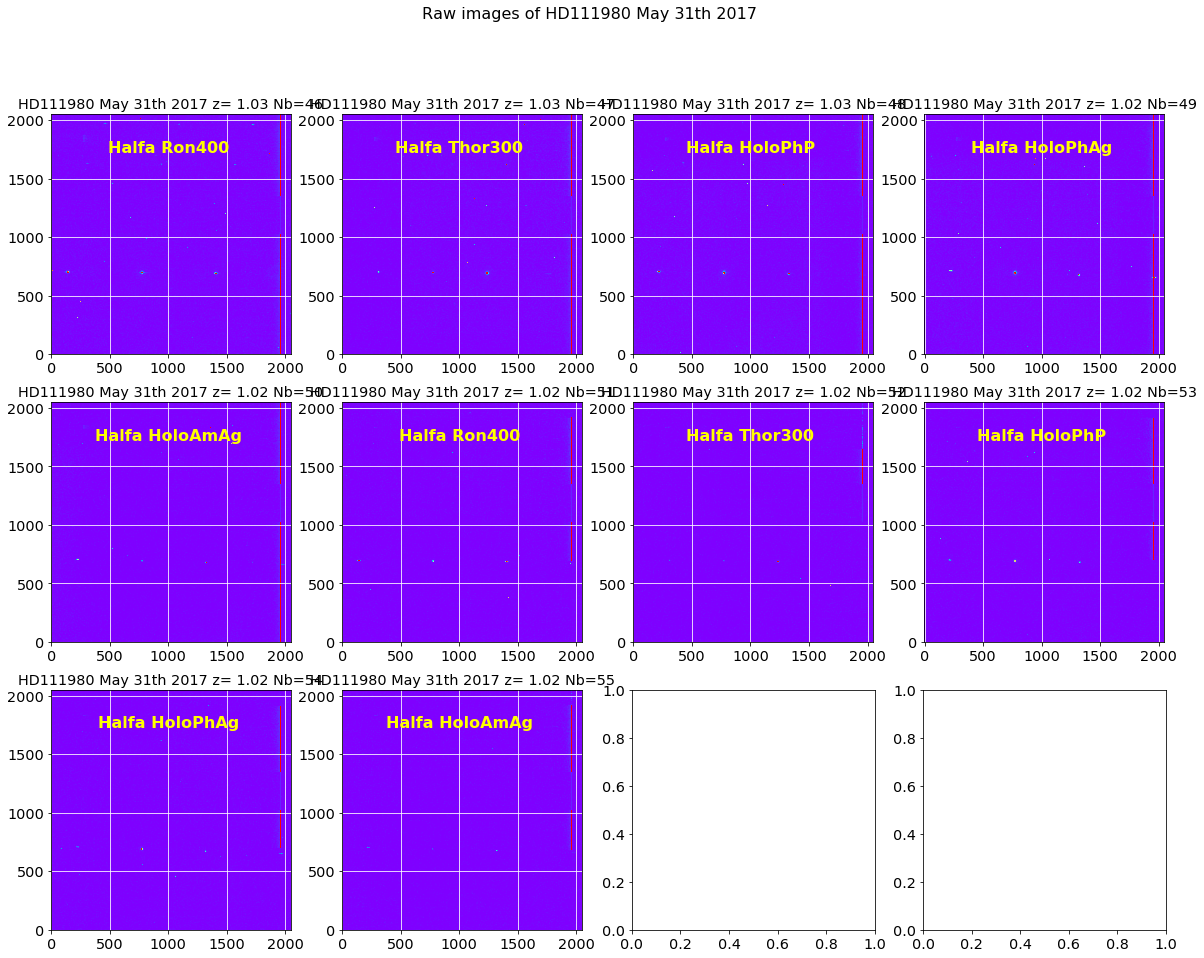

In [37]:
ShowRawImages()

### Find the star locations
----------------------------

In [38]:
#%%cython
#import photutils
#from astropy.stats import sigma_clipped_stats
#from photutils import daofind
#import numpy as np
from photutils import DAOStarFinder

def ComputeStatImagesFast(all_images,minx=500,maxx=1000,miny=500,maxy=1000):
    """
    ComputeStatImagesFast: 
    =======================
    
    - preselection of a sub-image
    """
    
    img_mean=[]
    img_median=[]
    img_std=[]
    img_sources=[]
    img_=[]
    index=0
    shiftx=minx
    shifty=miny
    for image in all_images:
        subimage=np.copy(image[miny:maxy,minx:maxx])
        subimage.shape
        mean, median, std = sigma_clipped_stats(subimage, sigma=5.0, iters=5)    
        #print '-------------------------------------------------------------------------------------------------------'
        #print index,' mean, median, std = ',mean, median, std
        img_mean.append(mean)
        img_median.append(median)
        img_std.append(std)
        subimage_nobg=subimage - median
        profx=subimage_nobg.sum(axis=0)
        profy=subimage_nobg.sum(axis=1)
        #plt.figure()
        #plt.plot(profx,'b-')
        #plt.plot(profy,'r-')
        #plt.show()
        the_max_x=np.where(profx==profx.max())[0][0]
        the_max_y=np.where(profy==profy.max())[0][0]
        #print 'themax_x=',the_max_x
        #print 'themax_y=',the_max_y
        #daofind = DAOStarFinder(fwhm=5.0, threshold=100.*std) 
        #subimage_nobg=subimage - median
        #sources = daofind(subimage_nobg)
        #plt.figure()
        #plt.imshow(subimage,origin='lower',cmap='rainbow',vmin=0, vmax=800)
        #plt.show()
        orig_x=shiftx+the_max_x
        orig_y=shifty+the_max_y
        sources=np.array([orig_y,orig_x])
        img_sources.append(sources)    
        index+=1
    return img_mean,img_median,img_std,img_sources,shiftx,shifty,the_max_x,the_max_y

In [39]:
img_mean,img_median,img_std,img_sources,shiftx,shifty,the_max_x,the_max_y=ComputeStatImagesFast(all_images,minx=500,maxx=1000,miny=500,maxy=900)

In [40]:
img_sources

[array([694, 776]),
 array([695, 776]),
 array([693, 776]),
 array([692, 777]),
 array([692, 776]),
 array([691, 776]),
 array([692, 776]),
 array([691, 776]),
 array([691, 775]),
 array([691, 774])]

### Cut the image
------------------

In [41]:
DeltaY=200
DeltaX=600

In [42]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
import os

def ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images):
    """
    ShowCenterImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=max(2,int(m.ceil(float(NBIMAGES)/float(NBIMGPERLROW))))
    
    #global dir_top_images
    
    croped_images = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(22,2*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        y0=int(positions_central[index][0])
        x0=int(positions_central[index][1])
       
        #image_cut=all_images[index][y0-200:y0+200,x0-200,y0+200]
        theimage=all_images[index]
        #image_cut=theimage[y0-DeltaY:y0+DeltaY,x0-DeltaX:x0+DeltaX]
        image_cut=np.copy(theimage[y0-DeltaY:y0+DeltaY,:])
        croped_images.append(image_cut)
        #aperture=CircularAperture([positions_central[index]], r=100.)
        im=axarr[iy,ix].imshow(image_cut,cmap='rainbow',vmin=0,vmax=1000,origin='lower',interpolation='None')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        #aperture.plot(color='red', lw=5.)
    title='Cut Images of {}'.format(object_name)
    plt.suptitle(title,size=16) 
    
    figfilename=os.path.join(dir_top_images,'cut_images.pdf')
    plt.savefig(figfilename)   
    
    
    return croped_images

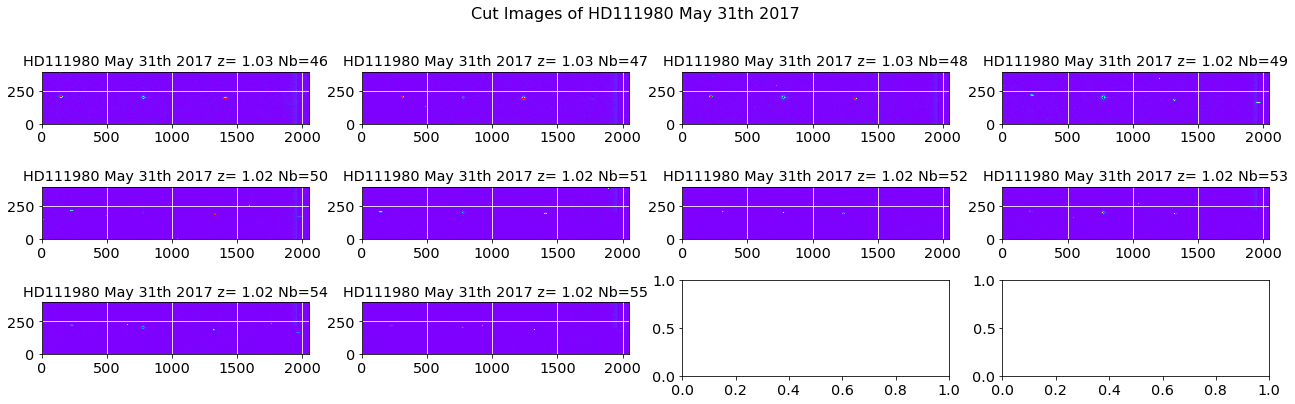

In [43]:
images_cut=ShowCenterImages(all_images,all_titles,object_name,img_sources,dir_top_images)

#### Example of cut image
-------------------------

In [44]:
index=0
data=np.copy(images_cut[index])
w=20
ws=80
data[:,DeltaX-ws:DeltaX+ws]=0

In [45]:
yprofile=np.sum(data,axis=1)
xprofile=np.sum(data,axis=0)

In [46]:
y_center=np.where(yprofile==yprofile.max())[0][0]
print y_center

200


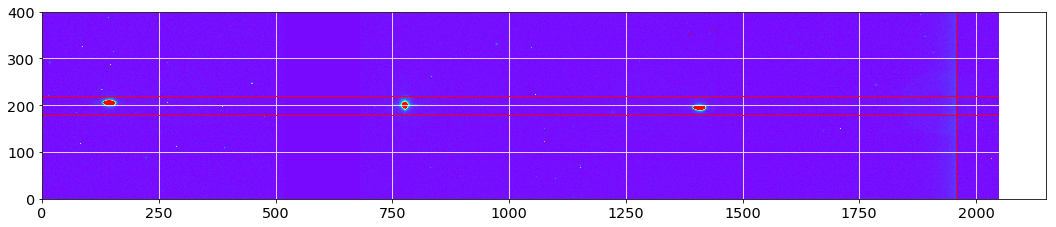

In [47]:
plt.figure(figsize=(18,18))
#y0=int(positions_central[index][0])
#x0=int(positions_central[index][1])
plt.imshow(data,vmin=-10,vmax=800,origin='lower',cmap='rainbow',interpolation='None')
plt.plot([0,data.shape[1]],[y_center-w,y_center-w],'r-',lw=1)
plt.plot([0,data.shape[1]],[y_center+w,y_center+w],'r-',lw=1)
plt.grid(color='white', ls='solid')
plt.show()
figfilename=os.path.join(dir_top_images,'cutimages_sample.pdf')
plt.savefig(figfilename)   

### prepare outputfilename

In [48]:
sorted_files

array(['reduced_fitsimages/reduc_20170531_046.fits',
       'reduced_fitsimages/reduc_20170531_047.fits',
       'reduced_fitsimages/reduc_20170531_048.fits',
       'reduced_fitsimages/reduc_20170531_049.fits',
       'reduced_fitsimages/reduc_20170531_050.fits',
       'reduced_fitsimages/reduc_20170531_051.fits',
       'reduced_fitsimages/reduc_20170531_052.fits',
       'reduced_fitsimages/reduc_20170531_053.fits',
       'reduced_fitsimages/reduc_20170531_054.fits',
       'reduced_fitsimages/reduc_20170531_055.fits'], 
      dtype='|S42')

In [49]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):   
    short_infilename=file.split("/")[1]
    short_partfilename=re.findall('^reduc_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

### Save outputfilename

In [50]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)



In [51]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jun 14 12:00 cut_fitsimages/cutimg_20170531_046.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jun 14 12:00 cut_fitsimages/cutimg_20170531_047.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jun 14 12:00 cut_fitsimages/cutimg_20170531_048.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jun 14 12:00 cut_fitsimages/cutimg_20170531_049.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jun 14 12:00 cut_fitsimages/cutimg_20170531_050.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jun 14 12:00 cut_fitsimages/cutimg_20170531_051.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jun 14 12:00 cut_fitsimages/cutimg_20170531_052.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jun 14 12:00 cut_fitsimages/cutimg_20170531_053.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 Jun 14 12:00 cut_fitsimages/cutimg_20170531_054.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6

In [52]:
textfilename=os.path.join(outputdir,'star_centroids.txt')
print textfilename
np.savetxt(textfilename,img_sources,header="y_star x_star",fmt='%d')

./cut_fitsimages/star_centroids.txt
